In [1]:
%load_ext autoreload
%autoreload 2

#### 1. Set up the reaction graph from DFT data 

In [3]:
from arcs.arcs.generate import GraphGenerator

graph = GraphGenerator().from_file(
    filename='../app/data/dft_data.json',
    temperature=248,
    pressure=20,
    max_reaction_length=5
)

ModuleNotFoundError: No module named 'arcs'

#### 2. Sample the `graph`

In [51]:
from arcs.traversal import Traversal
from arcs.generate import GenerateInitialConcentrations

gic = GenerateInitialConcentrations(graph=graph).update_ic(
    {'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':10}
    #{'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':10}
    #{'H2O':30,'SO2':10}
    )

t = Traversal(graph=graph)

data = t.sample(initial_concentrations=gic,ncpus=4,nsamples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

#### 3. generate reaction statistics

In [52]:
from arcs.analysis import AnalyseSampling
import pandas as pd 

analysis = AnalyseSampling()
stats = pd.Series(analysis.reaction_statistics(data)).sort_values(ascending=False)
stats.head(10)

1 H2 + 1 SO2 = 1 O2 + 1 H2S              328
1 H2O + 1 SO2 = 1 H2SO3                  290
2 H2 + 1 O2 = 2 H2O                      262
1 H2O + 1 NO2 + 1 NO = 2 HNO2            134
3 H2 + 1 SO2 = 2 H2O + 1 H2S             132
3 O2 + 2 H2S = 2 H2O + 2 SO2             111
1 H2 + 1 SO2 + 1 NO2 = 1 H2SO3 + 1 NO     92
1 H2O + 2 NO2 = 1 HNO3 + 1 HNO2           74
1 H2 + 1 H2SO4 = 2 H2O + 1 SO2            71
2 H2S + 6 SO2 + 2 N2 = 1 S8 + 4 HNO3      64
dtype: int64

#### 4. generate mean concentrations and differences

In [53]:
average_data = analysis.average_sampling(data)
average_data = average_data.loc[~(average_data==0).all(axis=1)]
average_data.round(5)
average_data.sort_values(by='diff',inplace=True)
average_data.round(2)

,initial,mean,diff,std,var
H2S,10.0,4.84,-5.16,4.67,21.83
NO2,10.0,5.84,-4.16,4.92,24.23
O2,10.0,5.98,-4.02,5.60,31.32
H2O,30.0,30.01,0.01,4.58,20.98
S8,0.0,0.10,0.10,0.32,0.10
NH3,0.0,0.14,0.14,0.92,0.85
NOHSO4,0.0,0.42,0.42,1.44,2.09
H2SO3,0.0,0.42,0.42,1.97,3.90
N2,0.0,0.45,0.45,1.36,1.84
HNO3,0.0,0.60,0.60,1.64,2.69


#### 5. Plot 

<Axes: >

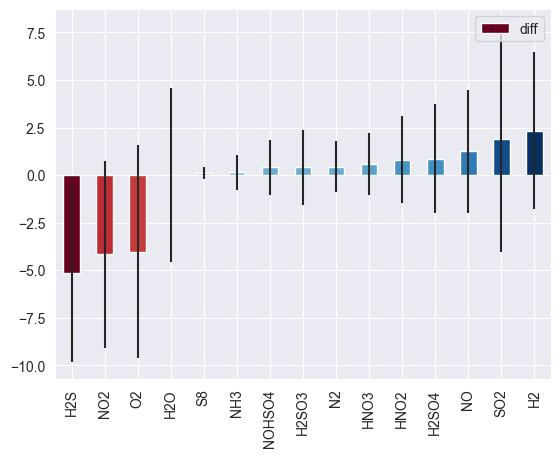

In [54]:
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

sns.set_style('darkgrid')
sns.set_palette('pastel')


norm = colors.Normalize(vmin=average_data['diff'].min(), vmax=average_data['diff'].max())
cmap = cm.RdBu  # or any other colormap

bar_colors = [cmap(norm(value)) for value in average_data['diff']]

average_data.plot.bar(y='diff',yerr='std',color=bar_colors)

#### 5. generate a `pyvis` graph 

In [55]:
g = analysis.result_to_pyvis(data,head=10,filename='example_pyvis_graph.html')